# Retail Sales Forecasting com Exógena

Dados de vendas no varejo para prever resultados com histórico limitado, eventos sazonais e promoções. Os dados cobrem 45 lojas, com promoções antes de feriados importantes. Semanas com esses feriados têm peso extra, e o desafio é prever o impacto nos departamentos.

Link da base no kaggle: https://www.kaggle.com/datasets/manjeetsingh/retaildataset?select=sales+data-set.csv


__Documentação dos dados:__

Store: Número identificador da loja (tipo inteiro). <br>
Dept: Número identificador do departamento (tipo inteiro). <br>
Date: Data de registro das vendas (tipo texto, object). <br>
Weekly_Sales: Valor das vendas semanais (tipo float). <br>
IsHoliday: Indicador de feriado (tipo bool). <br>


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
# Carregando os dados
data = pd.read_csv("sales_dataset.csv", parse_dates=["Date"])
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.set_index("Date", inplace=True)

In [59]:
correlation = data['Weekly_Sales'].corr(data['IsHoliday'])
print("Correlação entre Vendas Semanais e IsHoliday:", correlation)


Correlação entre Vendas Semanais e IsHoliday: 0.0127742203748548


Visto o percentual, vemos que é muito baixa a correlação.

In [ ]:
# Filtrando para uma única loja e departamento (exemplo: Store 1, Dept 1)
store_dept_data = data[(data['Store'] == 1) & (data['Dept'] == 1)]

In [ ]:
# Transformando a coluna 'IsHoliday' de booleano para 0 e 1
data['IsHoliday'] = data['IsHoliday'].astype(int)

In [64]:
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,0
2010-02-12,1,1,46039.49,1
2010-02-19,1,1,41595.55,0
2010-02-26,1,1,19403.54,0
2010-03-05,1,1,21827.90,0


In [ ]:
# Verificando valores negativos na coluna 'Weekly_Sales'
negative_values = (data['Weekly_Sales'] < 0).sum()

# Exibindo o resultado
if negative_values > 0:
    print(f"Há {negative_values} valores negativos na coluna 'Weekly_Sales'.")
else:
    print("Não há valores negativos na coluna 'Weekly_Sales'.")


Há 1285 valores negativos na coluna 'Weekly_Sales'.


In [ ]:
# Removendo valores negativos na coluna 'Weekly_Sales'
data = data[data['Weekly_Sales'] >= 0]

In [67]:
# Verificar valores negativos na coluna 'Weekly_Sales'
negative_values = (data['Weekly_Sales'] < 0).sum()

# Exibir o resultado
if negative_values > 0:
    print(f"Há {negative_values} valores negativos na coluna 'Weekly_Sales'.")
else:
    print("Não há valores negativos na coluna 'Weekly_Sales'.")

Não há valores negativos na coluna 'Weekly_Sales'.


In [ ]:
# Removendo valores negativos na coluna 'Weekly_Sales'
data = data[data['Weekly_Sales'] >= 0]


In [69]:
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,0
2010-02-12,1,1,46039.49,1
2010-02-19,1,1,41595.55,0
2010-02-26,1,1,19403.54,0
2010-03-05,1,1,21827.90,0


In [ ]:
# série temporal de vendas semanais e a coluna `IsHoliday`
sales_data = store_dept_data['Weekly_Sales']
is_holiday_data = store_dept_data['IsHoliday']

In [ ]:
#  os dados em treino e teste
train_size = int(len(sales_data) * 0.8)
train, test = sales_data[:train_size], sales_data[train_size:]
train_exog, test_exog = is_holiday_data[:train_size], is_holiday_data[train_size:]


In [ ]:
#  'IsHoliday' para valores numéricos 0 e 1
train_exog = train_exog.astype(int)
test_exog = test_exog.astype(int)

In [ ]:
#  modelo SARIMA com `IsHoliday` como variável exógena
model = SARIMAX(train, exog=train_exog, order=(3, 0, 1), seasonal_order=(1, 1, 1, 52))
model_fit = model.fit(disp=False)

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
# Previsões para o período de teste com `IsHoliday` como exógena
forecast = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=test_exog, dynamic=False)


In [ ]:
# Avaliando o modelo com RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'RMSE: {rmse:.2f}')

RMSE: 7434.95


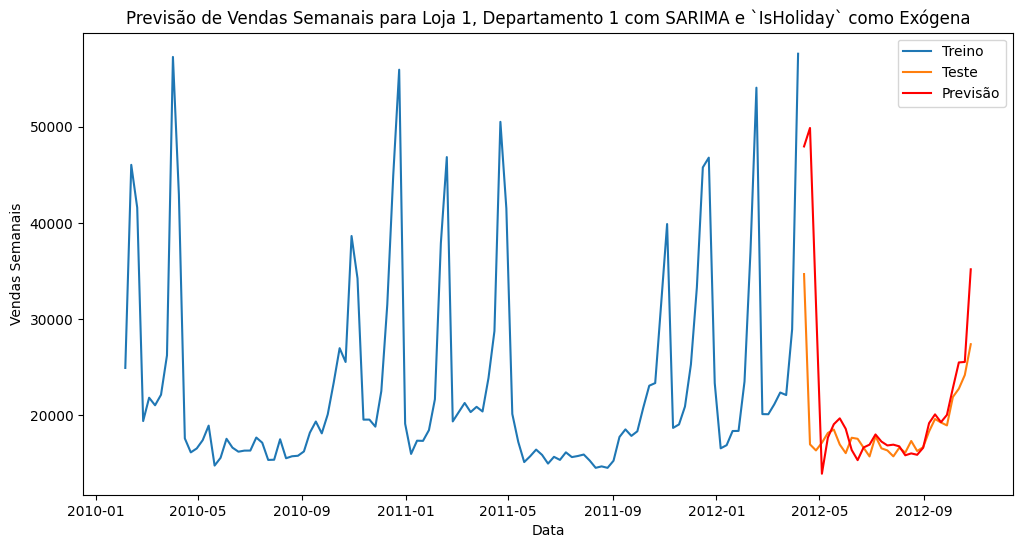

In [ ]:
# Visualizando o resultado
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Treino")
plt.plot(test.index, test, label="Teste")
plt.plot(test.index, forecast, color="red", label="Previsão")
plt.xlabel("Data")
plt.ylabel("Vendas Semanais")
plt.title("Previsão de Vendas Semanais para Loja 1, Departamento 1 com SARIMA e `IsHoliday` como Exógena")
plt.legend()
plt.show()

In [ ]:
# Calculando MAPE e Acurácia
mape = np.mean(np.abs((test - forecast) / test)) * 100
accuracy = 100 - mape

print("MAPE:", mape)
print("Acurácia:", accuracy)

MAPE: 17.313770922208143
Acurácia: 82.68622907779186
